In [5]:
import sys
# sys.path.append('/home/dev/.local/lib/python3.11/site-packages') # For development on VAST. Remove!

import torch
from IPython.display import display
from PIL import Image
import pandas as pd
import numpy as np
from rectpack import newPacker
import rectpack
import matplotlib.pyplot as plt
import warnings

import sys, os
sys.path.append(os.path.abspath('../'))
from utils.latex import crop_to_formula, renderedLaTeXLabelstr2Formula, display_formula
from data.datasets import renderedLaTeXDataset, set_seed
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

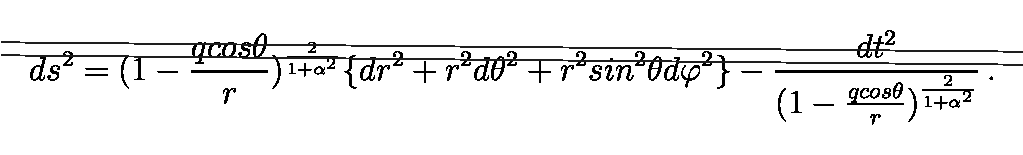

<IPython.core.display.Math object>

ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}\lbrace dr^2+r^2d\theta^2+r^2sin^2\theta d\varphi^2\rbrace -{dt^2\over  (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}} .



In [6]:
image_num = 1

train_filenames_df = pd.read_csv("../rendered_LaTeX/im2latex_train.lst", sep=" ", index_col = 0, header = None)
formula_image_example = Image.open("../formula_images/" + train_filenames_df.loc[image_num, 1] + ".png").convert('RGBA')
formulas = open("../rendered_LaTeX/im2latex_formulas.lst", encoding = "ISO-8859-1", newline="\n").readlines()

display(crop_to_formula(formula_image_example))

display_formula(renderedLaTeXLabelstr2Formula(formulas[image_num]))
print(renderedLaTeXLabelstr2Formula(formulas[image_num]))

In [7]:
def generate_page(images, p_lines = .5, in_scale=100, paper_width=8.5, paper_height=11):
    """
    takes in a list of PIL images and returns an image with them pasted on
    and pixel wise bounding boxes describing the top left and bottom right
    coordinates of the equation on the paper of the form (x1,y1,x2,y2)
    """
    color_channel = 'RGBA'

    bounding_boxes =  [None] * len(images)
    img_sizes = [x.size + (i,) for i,x in enumerate(images)]


    scaled_width = int(in_scale * paper_width)
    scaled_height = int(in_scale * paper_height)
    # generates non-overlapping bounding boxes
    packer = newPacker(rotation=False, pack_algo=rectpack.GuillotineBafMaxas)
    packer.add_bin(scaled_width, scaled_height)

    for r in img_sizes:
        packer.add_rect(*r)
    packer.pack()
    
    paper = Image.new(color_channel, (scaled_width, scaled_height), color=(255,255,255,255)) # generate white rectangle
    
    if np.random.rand(1) < p_lines:
        # red line
        red_distance = int(1.25 * in_scale)
        red_line = Image.new(color_channel, (2, scaled_height), color=(255,0,0,255))
        paper.paste(red_line, (red_distance,0))

        # blue lines
        blue_height = (9 * in_scale) //32
        
    for rect in packer.rect_list():
        b, x, y, w, h, rid = rect

        bounding_boxes[rid] = (x, y, x+w, y+h)
        paper.paste(images[rid], (x,y), images[rid])
        
    return paper, bounding_boxes

In [8]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
device = 'cuda'
train_ds = renderedLaTeXDataset(image_folder = "../formula_images/", 
                                lst_file = "../rendered_LaTeX/im2latex_train.lst", 
                                formulas_file = "../rendered_LaTeX/im2latex_formulas.lst", 
                                device = device,
                                processor = processor)

In [9]:
images = []
for image_num in range(1,9):
    train_filenames_df = pd.read_csv("../rendered_LaTeX/im2latex_train.lst", sep=" ", index_col = 0, header = None)
    formula_image_example = Image.open("../formula_images/" + train_filenames_df.loc[image_num, 1] + ".png").convert('RGBA')

    img = crop_to_formula(formula_image_example)
    img = np.asarray(img.convert('RGBA')).copy()
    img[:, :, 3] = (255 * (img[:, :, :3] != 255).any(axis=2)).astype(np.uint8)
    img = Image.fromarray(img)

    images.append(img)

paper, boxes = generate_page(images, p_lines=1, in_scale=200, paper_height = 4)

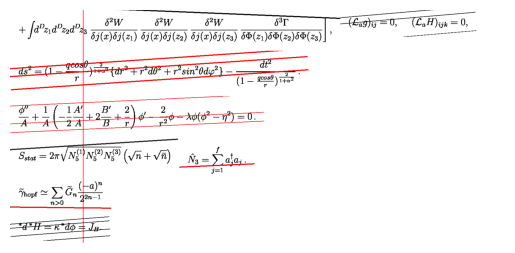

In [10]:
plt.imshow(paper)
plt.axis('off')
plt.show()

# plt.scatter([x[0] for x in boxes], [x[1] for x in boxes])

In [43]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
model_id = "IDEA-Research/grounding-dino-base"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to("cuda")

In [48]:
np.array(paper).shape

(800, 1700, 4)

In [57]:
processor.image_processor.size = {"height": 1024,
                                  "width": 1024}

[{'scores': tensor([0.3018, 0.3686, 0.1828, 0.1821, 0.1824, 0.1993, 0.1912, 0.1778, 0.1592,
        0.2235, 0.2712], device='cuda:0'), 'labels': ['math formula term', 'math formula term', 'math formula term', 'math formula term', 'math formula term', 'math formula term', 'math formula term', 'math formula term', 'math formula term', 'math formula term', 'math formula term'], 'boxes': tensor([[2.5978e+00, 2.0382e+01, 1.0811e+03, 7.8903e+02],
        [6.5449e+00, 3.0927e+00, 1.6621e+03, 7.9362e+02],
        [2.4655e+01, 4.7007e+02, 5.5156e+02, 5.3055e+02],
        [5.5717e+01, 3.9187e+01, 2.6343e+02, 1.0297e+02],
        [1.3007e+00, 7.0710e+02, 3.4441e+02, 7.8507e+02],
        [9.8219e+00, 1.8293e+02, 7.3412e+02, 2.3558e+02],
        [7.7598e+02, 2.1489e+02, 9.7848e+02, 2.6786e+02],
        [5.7862e+02, 4.6828e+02, 8.3898e+02, 5.6447e+02],
        [2.6826e+02, 1.8690e+02, 7.3211e+02, 2.3308e+02],
        [2.7344e+02, 6.9133e+01, 1.0750e+03, 1.1547e+02],
        [8.3996e+00, 3.2246e+02, 

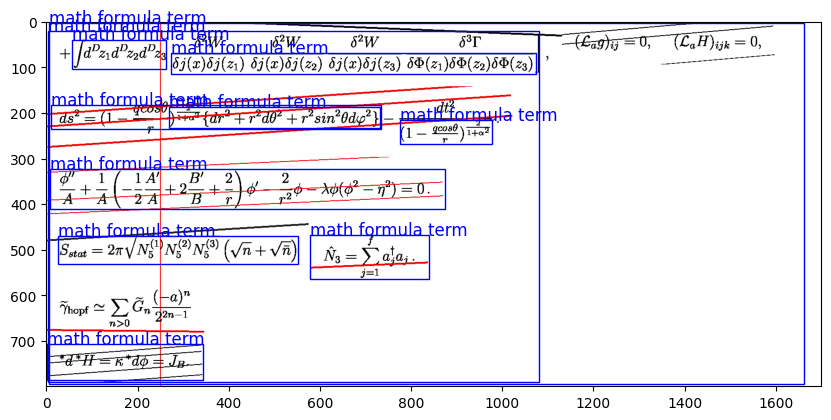

In [49]:
text = "math formula term."

inputs = processor(images=paper.convert("RGB"), text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.15,
    text_threshold=0.15,
    target_sizes=[paper.size[::-1]]
)
print(results)

# Draw boxes on the image
import matplotlib.patches as patches
bboxes = results[0]["boxes"]
labels = results[0]["labels"]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(paper)
for bbox, label in zip(bboxes, labels):
    bbox = bbox.cpu().numpy()
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1], label, fontsize=12, color='blue')

In [18]:
import requests
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
# Check for cats and remote controls
text = "an animal. a remote control."

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)
print(results)

[{'scores': tensor([0.4508, 0.4190, 0.5036], device='cuda:0'), 'labels': ['an animal', 'an animal', 'a remote control'], 'boxes': tensor([[ 12.3024,  52.1511, 316.7259, 472.3386],
        [344.4244,  23.3057, 636.9630, 374.6104],
        [ 38.3021,  69.6951, 177.0112, 118.4101]], device='cuda:0')}]
